# 关于折现率的理解

## 1. 初始定义

考虑一家企业，初始资金100万元，在10年内连续经营，每年能取得15%的净利润，并将所有净利润都投入再生产。

由此，我们可以计算每年的净资产，以及每年新增收入，再将这些新增收入折现回来，加和到一起，则可以计算出当前的内在价值。

关于折现率，可参考无风险长期定期存款利率，这里使用5%。

In [1]:
suppressMessages(library(tidyverse))

gen_table = function(init = 100, year = 10, growth = 0.15, discount_rate = 0.05) {
  a = data.frame(t = 0:year) # 初始化年份（0表示初始时间，1表示第一年，以此类推）
  a = a %>% mutate(asset = init * (1 + growth) ^ t) # 按照固定的增长率计算累计净资产
  a = a %>% mutate(earning = c(0, diff(asset))) # 每年增长部分，为新增收入，即待折现的部分
  a$present_value = 0
  for (i in 1:(year-1)) { # 循环计算每一年的折现值，需要把此后各年份的收入都折现到当前年份，加和起来
      a$present_value[[i + 1]] = a %>%
        filter(t > i) %>%
        mutate(present = earning / ((1 + discount_rate) ^ row_number())) %>%
        with(sum(present))
  }
  a %>%
    mutate(price = asset + present_value, # 以当前净资产，加上未来收入的折现值之和，作为内在价值
           PB = price / asset,   # 计算市净率
           PE = price / earning) # 计算市盈率
}

gen_table()

t,asset,earning,present_value,price,PB,PE
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,100.0000,0.00000,0.00000,100.0000,1.000000,Inf
1,115.0000,15.00000,218.67039,333.6704,2.901482,22.244693
2,132.2500,17.25000,212.35391,344.6039,2.605701,19.977038
3,152.0875,19.83750,203.13410,355.2216,2.335640,17.906571
4,174.9006,22.81312,190.47768,365.3783,2.089062,16.016145
5,201.1357,26.23509,173.76647,374.9022,1.863926,14.290103
6,231.3061,30.17036,152.28444,383.5905,1.658368,12.714152
7,266.0020,34.69591,125.20275,391.2047,1.470684,11.275240
8,305.9023,39.90030,91.56259,397.4649,1.299320,9.961451


从上述表格可以看出，将未来10年的收益折现回来，第一年的内在价值为原始投入的3倍，而市盈率可达到22倍。

## 2. 调整参数

In [2]:
# 也可以调整参数，计算不同条件下的 PB 和 PE
gen_table(year = 20, growth = 0.2)

t,asset,earning,present_value,price,PB,PE
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,100.0000,0.00000,0.0000,100.000,1.000000,Inf
1,120.0000,20.00000,1862.8653,1982.865,16.523878,99.143267
2,144.0000,24.00000,1932.0086,2076.009,14.416727,86.500359
3,172.8000,28.80000,1999.8090,2172.609,12.572969,75.437814
4,207.3600,34.56000,2065.2395,2272.600,10.959681,65.758087
5,248.8320,41.47200,2127.0295,2375.861,9.548054,57.288326
6,298.5984,49.76640,2183.6145,2482.213,8.312881,49.877286
7,358.3181,59.71968,2233.0756,2591.394,7.232104,43.392625
8,429.9817,71.66362,2273.0658,2703.047,6.286424,37.718547


## 3. 不同增长率的PB和PE

若固定只对10年的收入进行折现，考虑不同的收入增长率（1% 到 30%），看对应的第一年 PB 和 PE 分别可以达到多少

In [3]:
a = data.frame(growth = (1:30)/100, PB = NA, PE = NA)
for (i in 1:nrow(a)) {
    d = gen_table(year = 10, growth = a$growth[[i]])
    a$PB[[i]] = d$PB[[2]]
    a$PE[[i]] = d$PE[[2]]
}

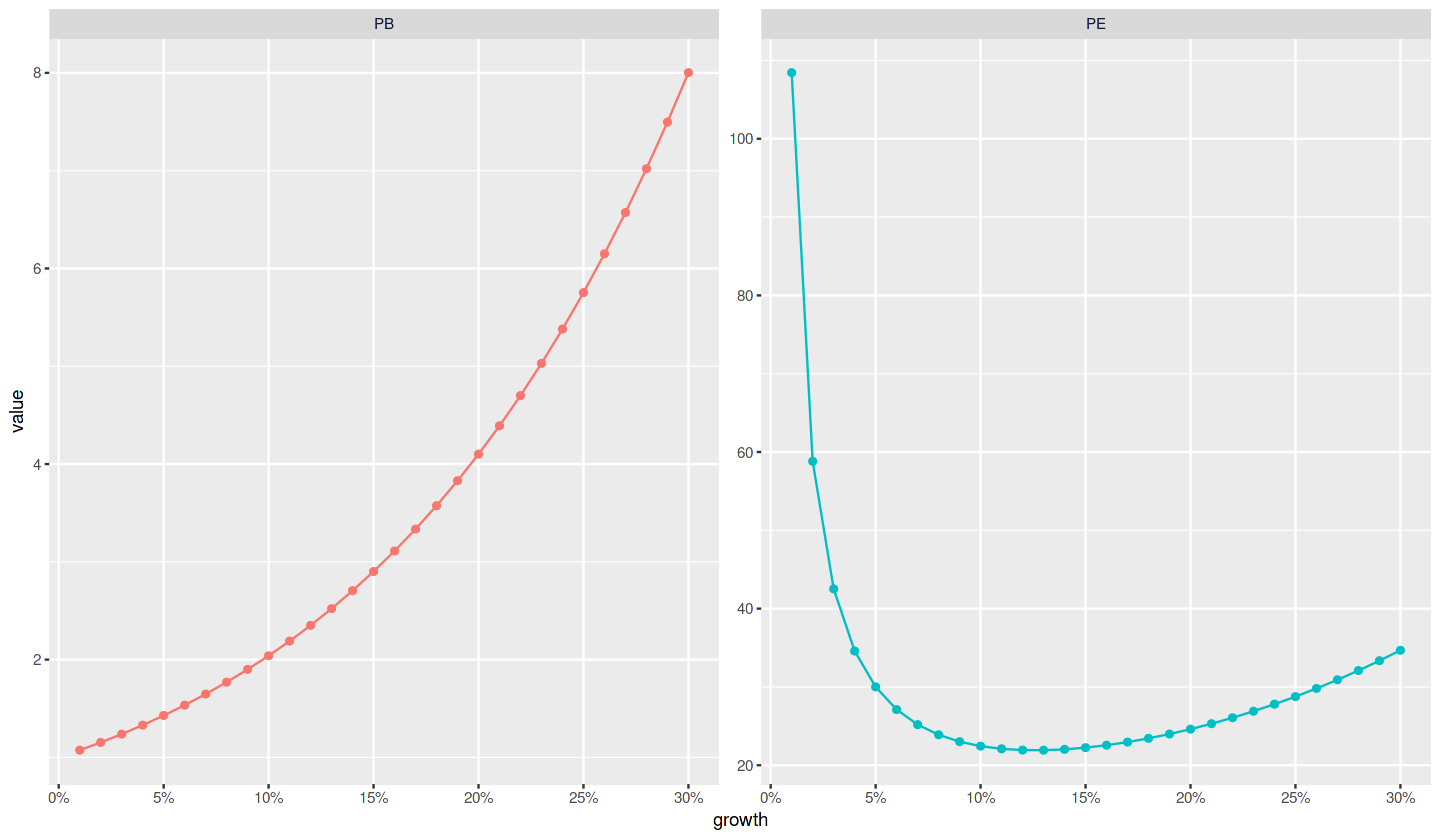

In [4]:
options(repr.plot.width = 12, repr.plot.height = 7)

a %>% pivot_longer(-growth) %>%
  ggplot(aes(x = growth, y = value, group = name, color = name)) +
  geom_point() +
  geom_line() +
  facet_wrap(~ name, ncol = 2, scales = "free_y") +
  scale_x_continuous(breaks = seq(from = 0, to = 30, by = 5) / 100,
                     labels = sprintf("%d%%", seq(from = 0, to = 30, by = 5)), minor_breaks = NULL) +
  guides(color = "none")